In [3]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
pip install --quiet git+https://github.com/theislab/scgen.git

Note: you may need to restart the kernel to use updated packages.


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### Import the metric -- scib

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.2 MB/s eta 0:00:00


In [2]:
!pip install --quiet louvain
import louvain

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-2-bf0d4c071418>:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be

In [3]:
import anndata
adata = anndata.read_h5ad("../bct_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 9288 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type'
    var: 'gene.symbols', 'gene.counts'

In [4]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.3 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 30% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 70% known labels and 30% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

In [5]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('../R_bct/labels/hard_label_bct_70.csv', index=True)

In [6]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [7]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [15]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [8]:
# Load the pretrained models
adata = adata.copy()
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [9]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

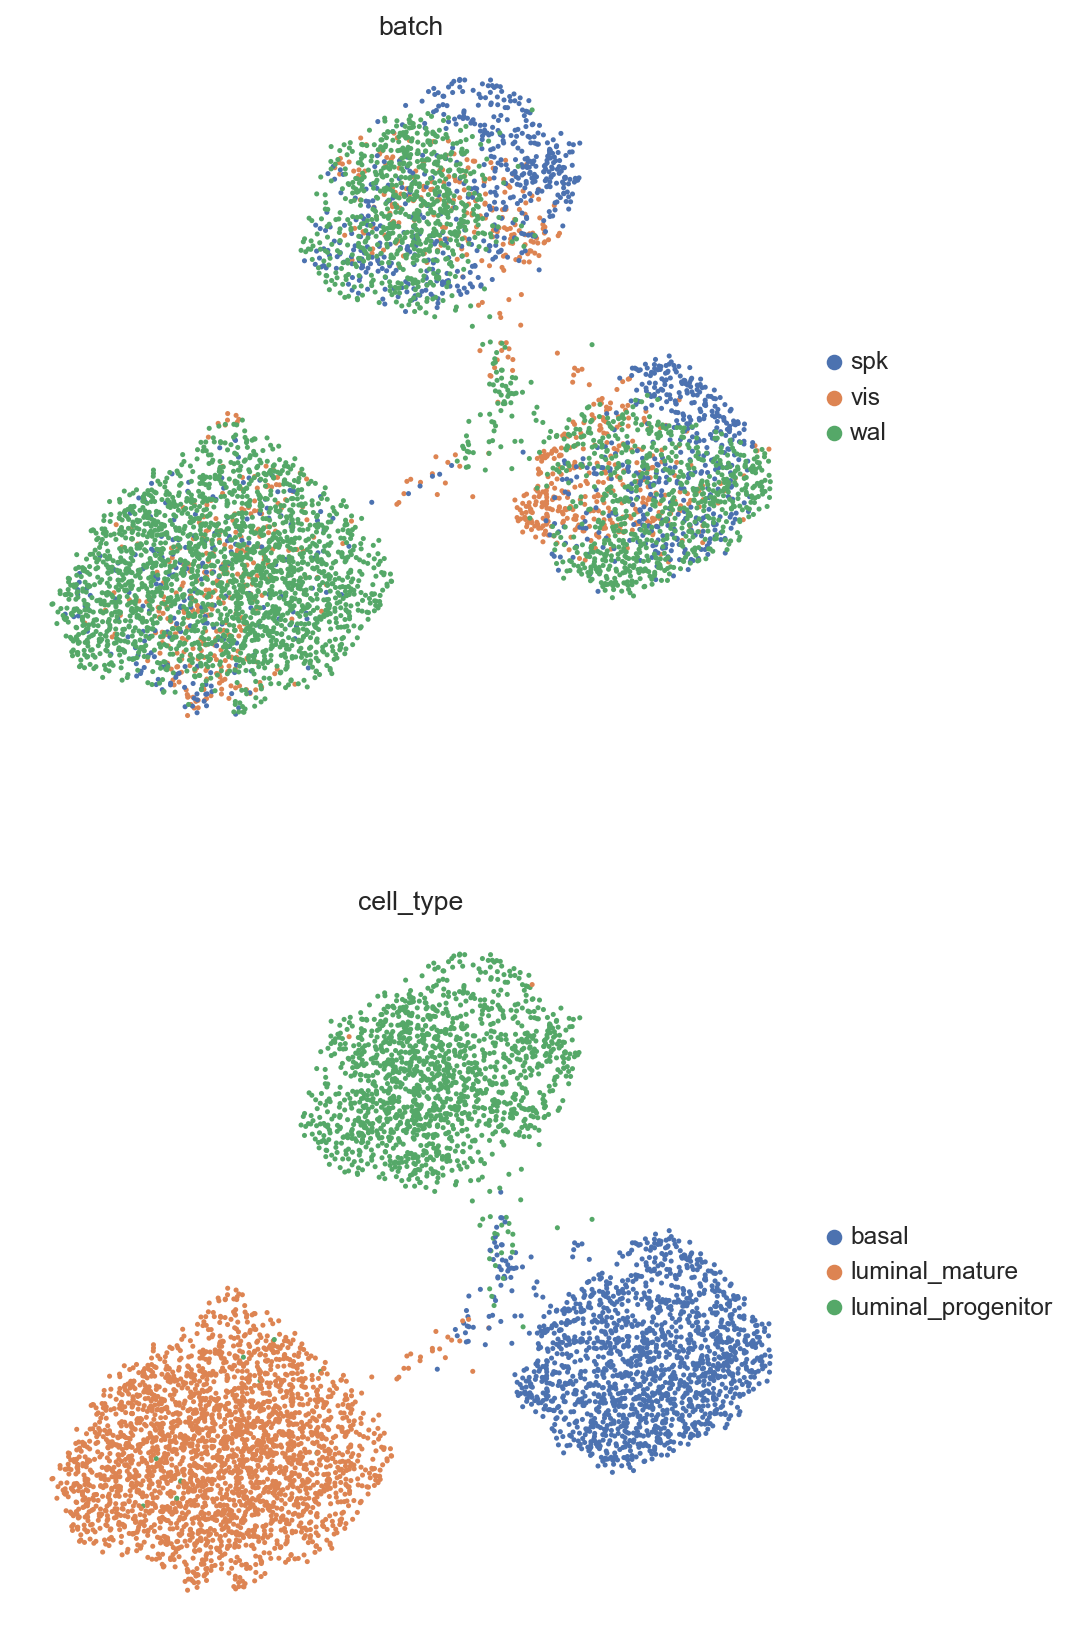

In [10]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [11]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

In [12]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [00:13<00:00,  1.54it/s, v_num=1, train_loss_step=1.2

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [00:13<00:00,  1.45it/s, v_num=1, train_loss_step=1.2


In [13]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [14]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [15]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

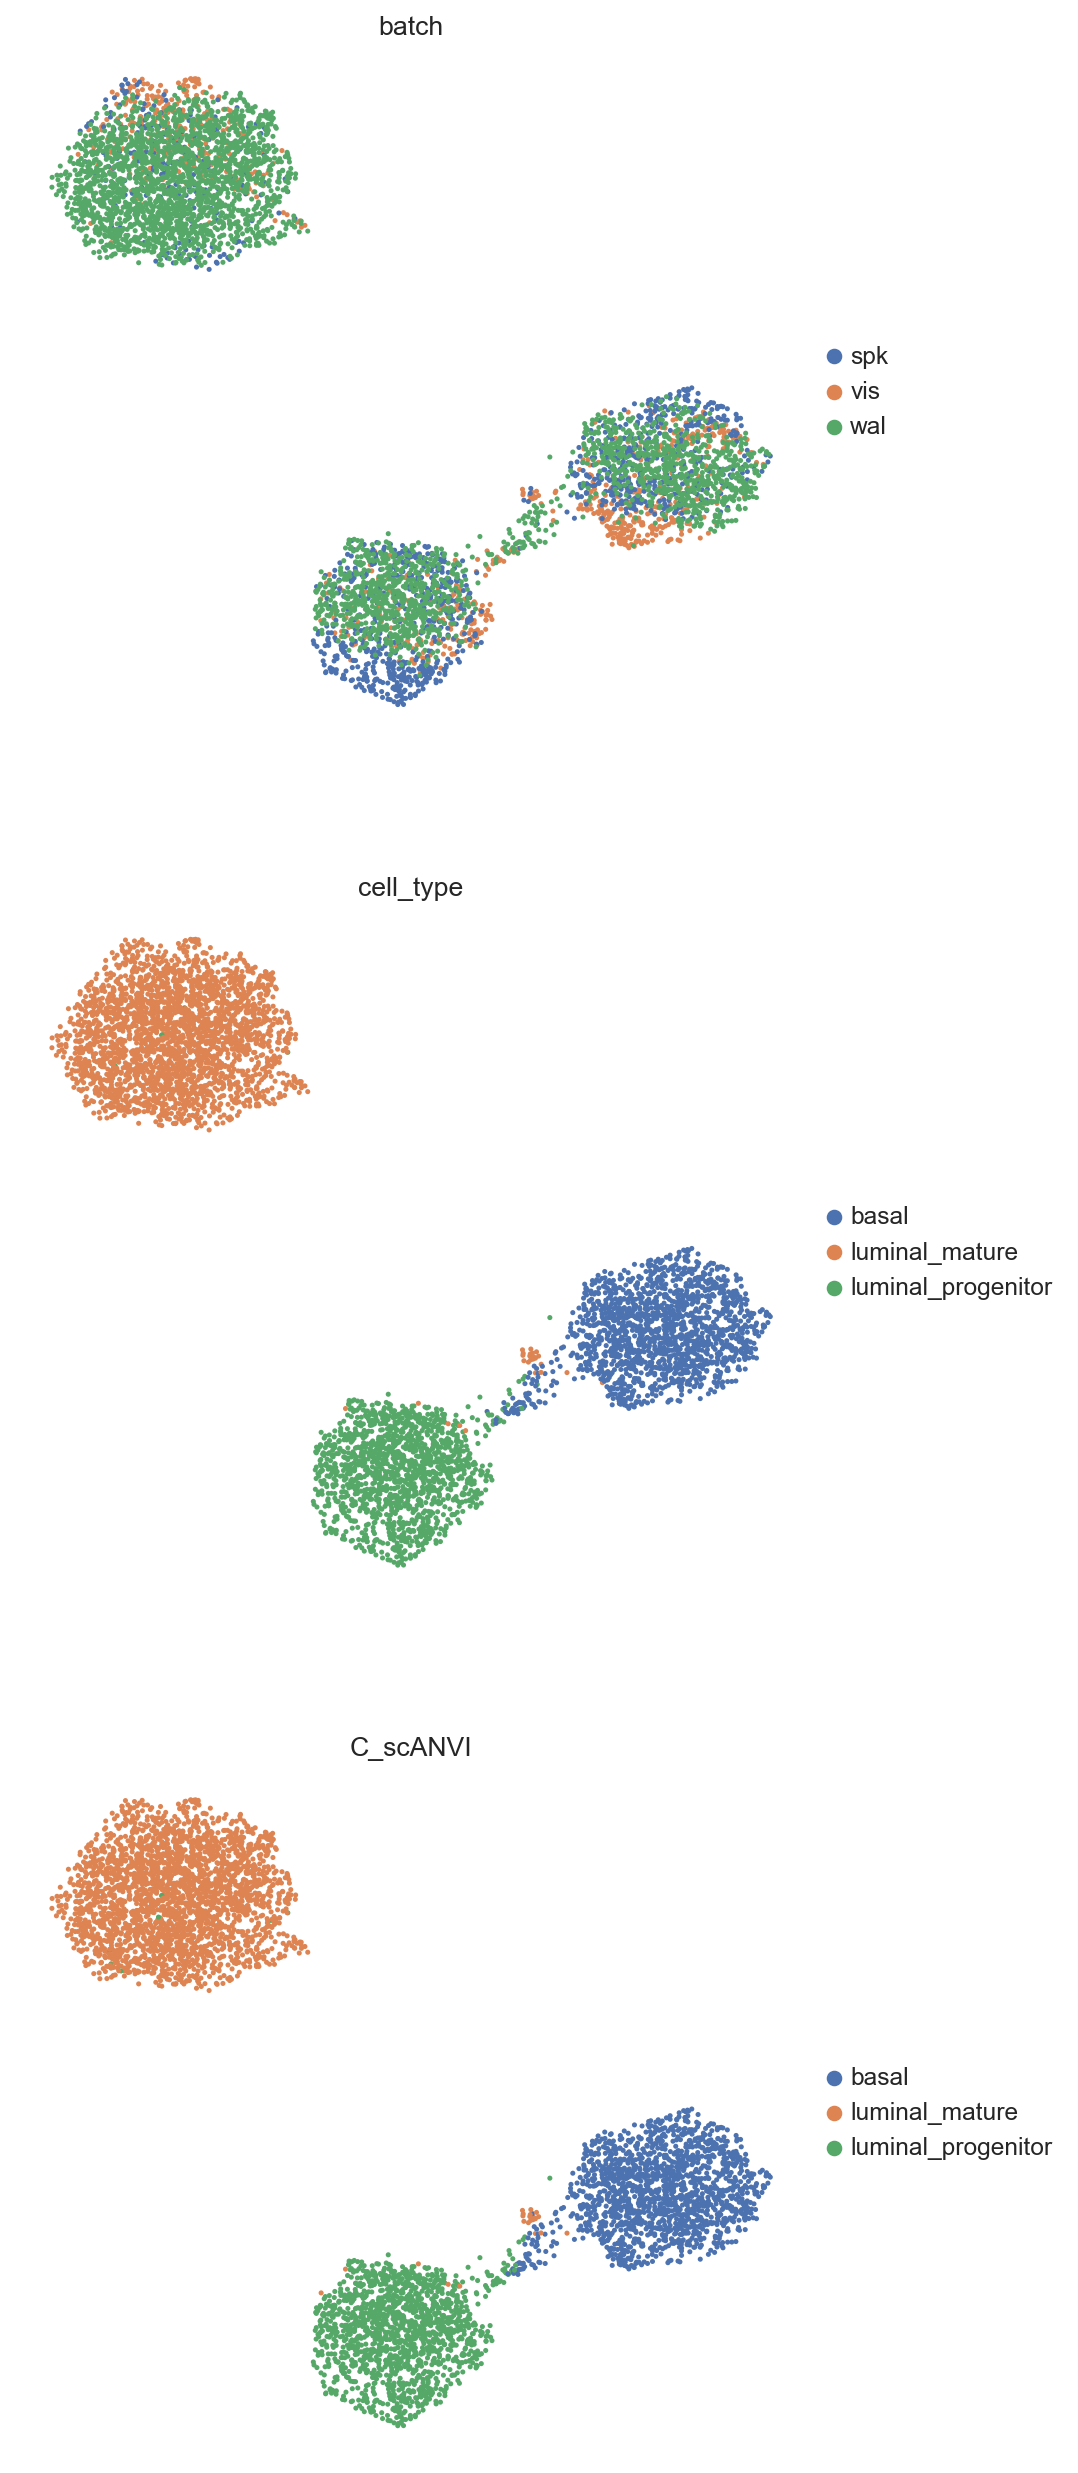

In [16]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [17]:
train = adata.copy()

### Preprocessing Data

In [18]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [19]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 27/100:  27%|▎| 27/100 [00:40<01:48,  1.49s/it, v_num=1, train_loss_step=4
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1546.047. Signaling Trainer to stop.


## Batch-Removal

In [20]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 5747 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type', 'hard_label', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [21]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [22]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

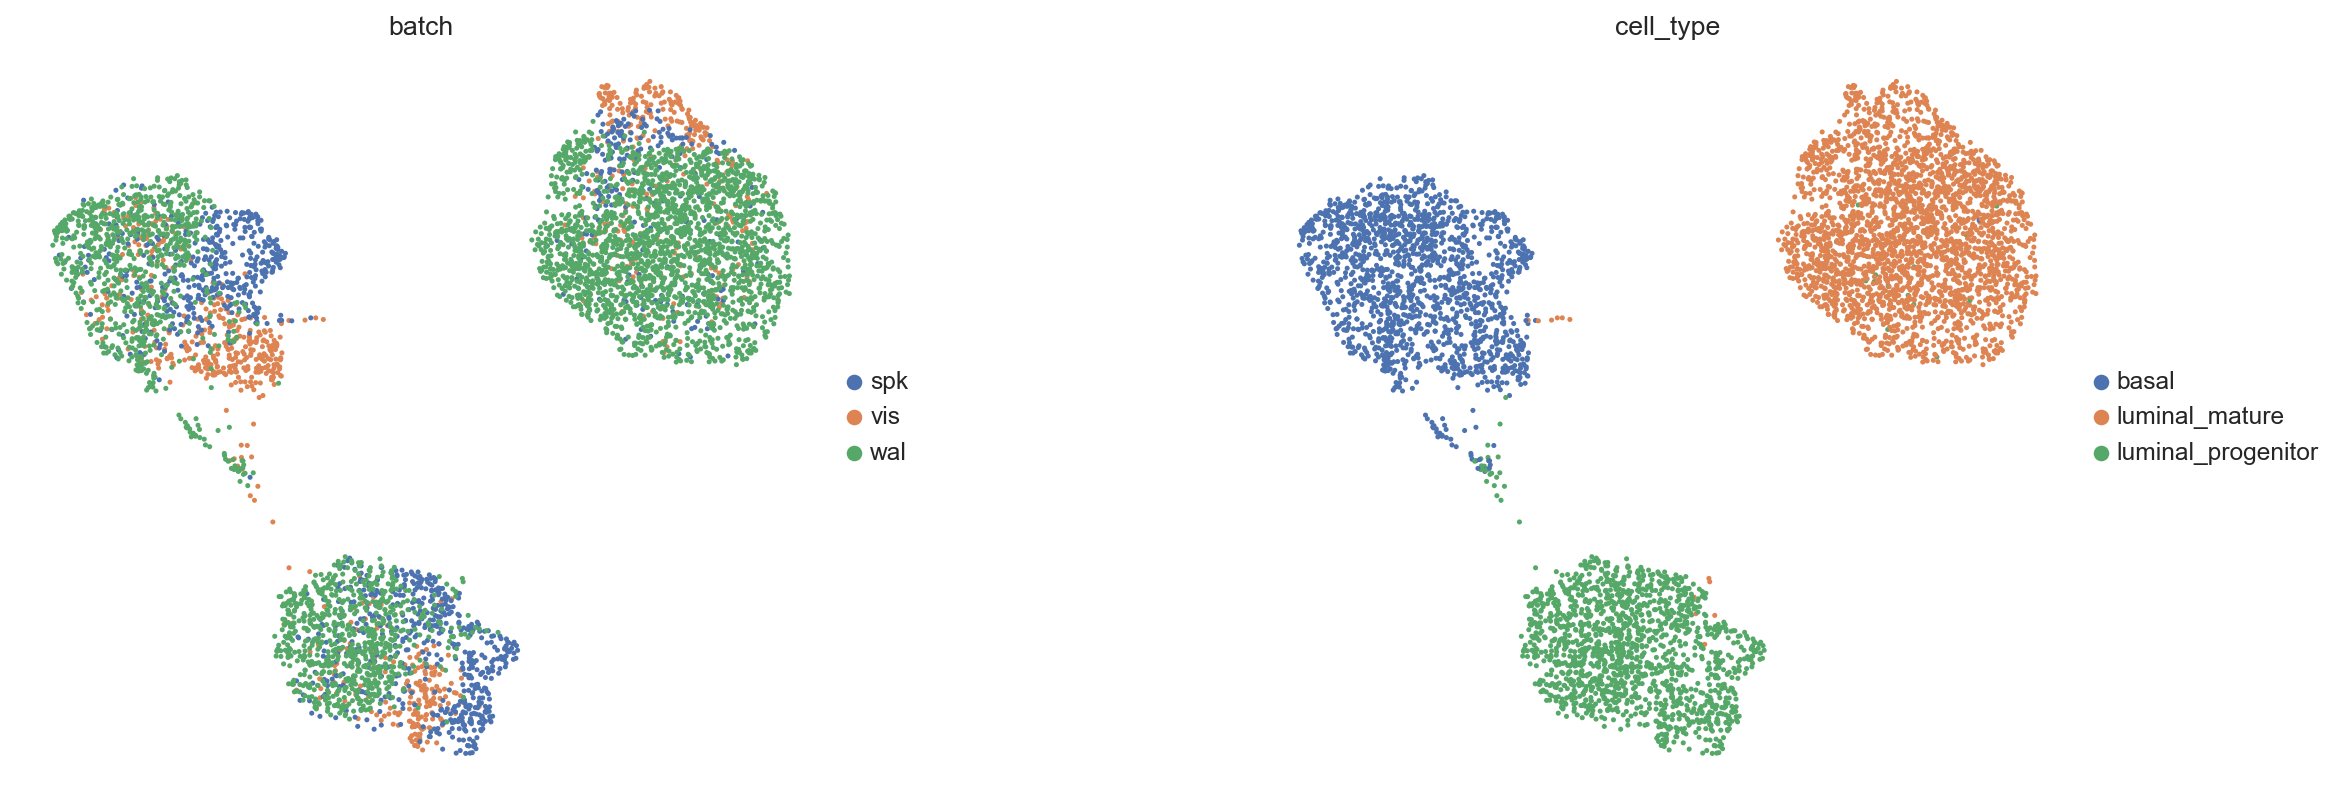

In [23]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [24]:
pca_embeddings = pd.read_csv('../R_bct/embeddings/bct_stacas_embeddings_randomly_missing_labels_70.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [25]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

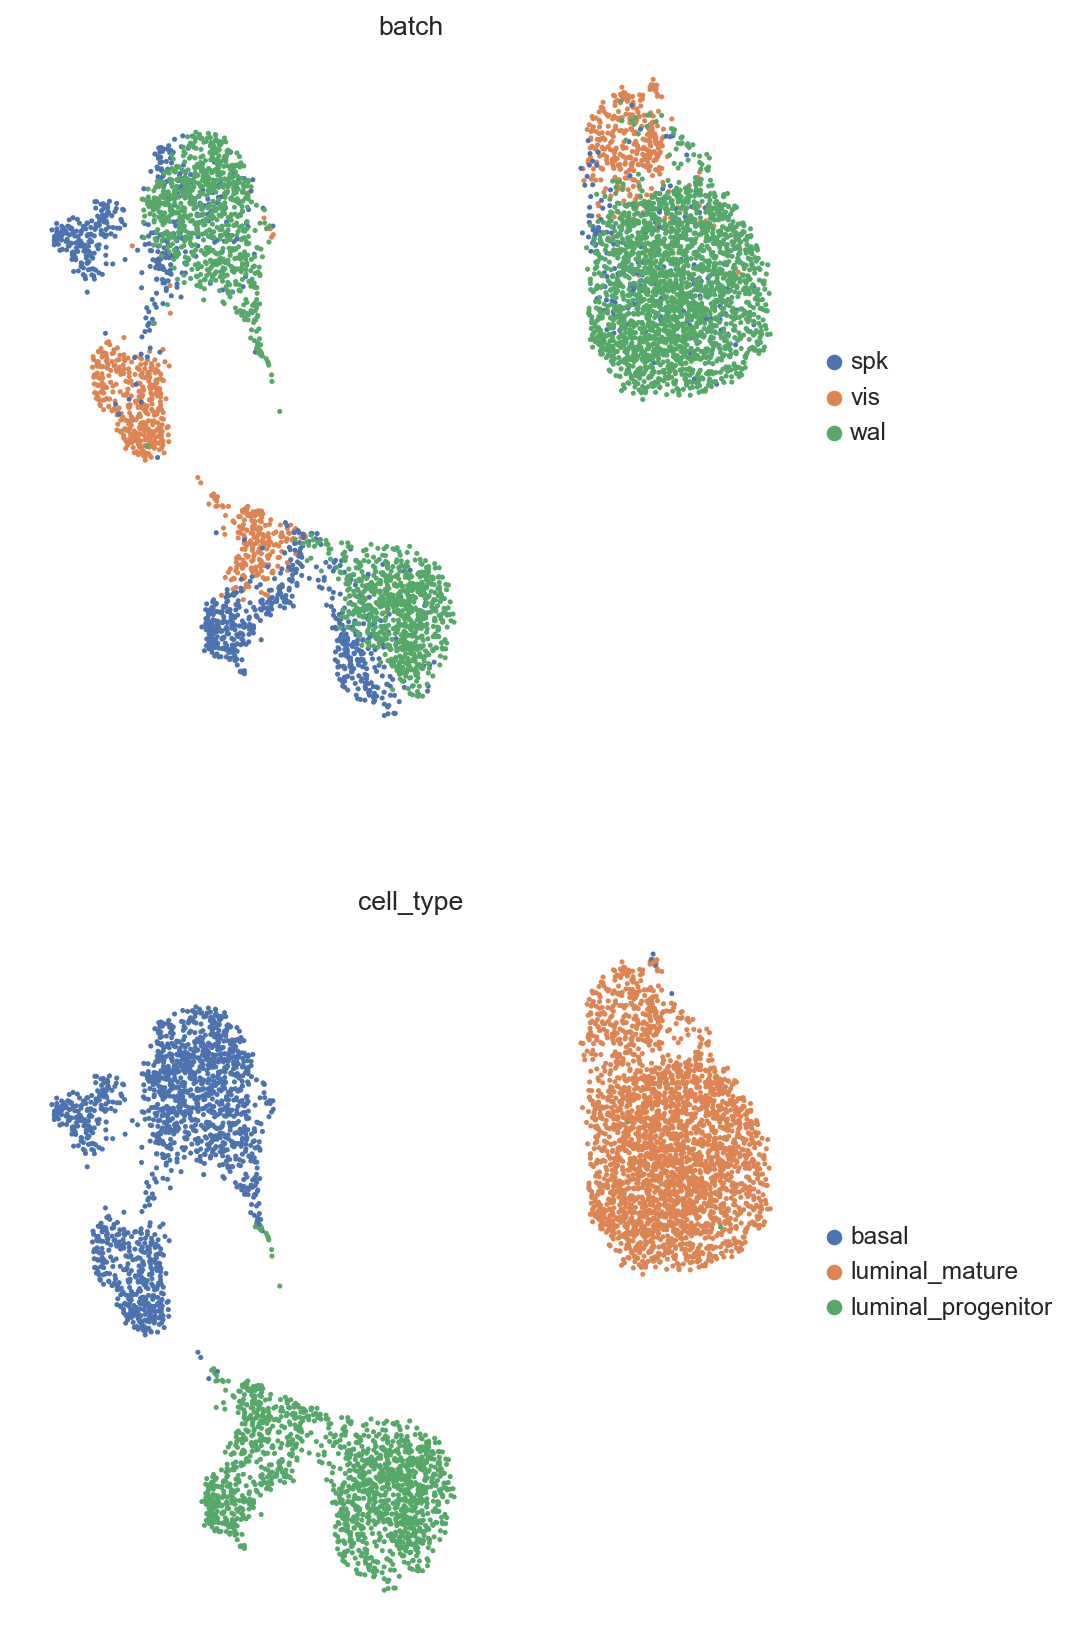

In [26]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [27]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_missing_bct_70.csv")


# Metric Evaluation

## read the embeddings

In [28]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/randomly_missing_bct_70.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [29]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.9464447349969799
resolution: 0.2, nmi: 0.9407593491167682
resolution: 0.3, nmi: 0.9407838901456358
resolution: 0.4, nmi: 0.9386911081798238
resolution: 0.5, nmi: 0.9392628518235988
resolution: 0.6, nmi: 0.9246928181873091
resolution: 0.7, nmi: 0.7993126158749329
resolution: 0.8, nmi: 0.7690535567014933
resolution: 0.9, nmi: 0.7025158792400001
resolution: 1.0, nmi: 0.6758313471422683
resolution: 1.1, nmi: 0.6400697250839807
resolution: 1.2, nmi: 0.6005960295861569
resolution: 1.3, nmi: 0.5632266687500594
resolution: 1.4, nmi: 0.5455012031064216
resolution: 1.5, nmi: 0.5198964543394329
resolution: 1.6, nmi: 0.5053594996914391
resolution: 1.7, nmi: 0.5014506469550548
resolution: 1.8, nmi: 0.503211420746007
resolution: 1.9, nmi: 0.4953091279809321
resolution: 2.0, nmi: 0.4780936343146426
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9464447349969799
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on

In [30]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.9615681718744835
resolution: 0.2, nmi: 0.8827372295112639
resolution: 0.3, nmi: 0.7835596074167386
resolution: 0.4, nmi: 0.7771556238103056
resolution: 0.5, nmi: 0.7804239183044035
resolution: 0.6, nmi: 0.7230164626945571
resolution: 0.7, nmi: 0.6914196728487635
resolution: 0.8, nmi: 0.6486580206790405
resolution: 0.9, nmi: 0.6141371207718148
resolution: 1.0, nmi: 0.5793347351470942
resolution: 1.1, nmi: 0.5705344846269698
resolution: 1.2, nmi: 0.5821626449401865
resolution: 1.3, nmi: 0.5542590648722964
resolution: 1.4, nmi: 0.5523768747661275
resolution: 1.5, nmi: 0.5374071681165244
resolution: 1.6, nmi: 0.5239620730055154
resolution: 1.7, nmi: 0.5274435141572374
resolution: 1.8, nmi: 0.5192030228298754
resolution: 1.9, nmi: 0.5120492822166949
resolution: 2.0, nmi: 0.5016809380366283
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9615681718744835
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [31]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.911895310175673
resolution: 0.2, nmi: 0.8197112155130251
resolution: 0.3, nmi: 0.7688740538251533
resolution: 0.4, nmi: 0.7645733555490773
resolution: 0.5, nmi: 0.7650973181104835
resolution: 0.6, nmi: 0.7626451529731169
resolution: 0.7, nmi: 0.6997805124688885
resolution: 0.8, nmi: 0.702583171529188
resolution: 0.9, nmi: 0.6389418583288955
resolution: 1.0, nmi: 0.6376427694836879
resolution: 1.1, nmi: 0.6410077974408636
resolution: 1.2, nmi: 0.6048791157642832
resolution: 1.3, nmi: 0.6046201999326805
resolution: 1.4, nmi: 0.5953240727296271
resolution: 1.5, nmi: 0.5795051284458992
resolution: 1.6, nmi: 0.5610014279605579
resolution: 1.7, nmi: 0.5595115843661088
resolution: 1.8, nmi: 0.5594426323412652
resolution: 1.9, nmi: 0.5524225168325181
resolution: 2.0, nmi: 0.542337285464152
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.911895310175673
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [32]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/bct_metrics_randomly_missing_70.csv", index=True)

In [33]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.949878,0.952341,0.977762
ARI_cluster/label,0.976310,0.975791,0.990574
ASW_label,0.582628,0.639255,0.684957
ASW_label/batch,0.958171,0.860444,0.874057
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.990176,0.992633,0.952341
isolated_label_silhouette,0.585208,0.626386,0.674769
graph_conn,1.000000,0.999103,1.000000
kBET,NaN,NaN,NaN
